# Exploring the simulation results

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import scipy
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tqdm import tqdm
from fitter import Fitter

from infant_abm.db_utils import load_run

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (6, 3.5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

## Helper

In [2]:
def running_avg(x, steps, m="same"):
    return np.convolve(x, np.ones(steps) / steps, mode=m)

In [3]:
def load_description(model, run_name):
    description_df, load_partial = load_run(f"results/{model}/{run_name}")
    result = load_partial(0)

    iterations = result["0"]["iterations"]
    repeats = len(result)
    n_samples = len(description_df)

    return n_samples, iterations, repeats, load_partial


def get_q_results(index):
    results = load_partial(index).values()

    rewards = np.array([r["rewards"] for r in results])
    rewards = np.average(rewards, axis=0)

    q_tables = [r["q_table"] for r in results]

    return rewards, q_tables


def load_v2run_results(model, run_name):
    description_df, _load_partial = load_run(f"results/{model}/{run_name}")

    results_df = description_df

    the_list = [get_q_results(index) for index in tqdm(results_df.index)]
    rewards, q_tables = zip(*the_list)

    results_df["rewards"] = rewards
    results_df["q_table"] = q_tables

    return results_df

In [52]:
MODEL = "v0.2.1"
RUN_NAME = "test_q_learnv2_100k"

N_SAMPLES, ITERATIONS, REPEATS, load_partial = load_description(MODEL, RUN_NAME)
results_df = load_v2run_results(MODEL, RUN_NAME)

100%|██████████| 144/144 [00:01<00:00, 113.73it/s]


In [53]:
results_df.head()

,perception,persistence,coordination,persistence_boost_value,coordination_boost_value,infant_kwargs,rewards,q_table
0,0.3,0.3,0.3,0.0,0.0,"{'alpha': 0.08, 'gamma': 0.5, 'epsilon': 0.005}","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[[2.4789193770629425, 7.831139511794107, 0.6254016411119605, 0.5611754460064323, 0.659963611624..."
1,0.3,0.3,0.3,0.0,0.0,"{'alpha': 0.08, 'gamma': 0.5, 'epsilon': 0.01}","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[3.3569367423538314, 7.578673255976173, 0.37698634077906984, 0.34656081537038014, 0.3597534003..."
2,0.3,0.3,0.3,0.0,0.0,"{'alpha': 0.08, 'gamma': 0.5, 'epsilon': 0.05}","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[3.173725889920783, 7.2093957044425405, 0.475409598688597, 0.4699848449400441, 0.5152621349959..."
3,0.3,0.3,0.3,0.0,0.0,"{'alpha': 0.08, 'gamma': 0.7, 'epsilon': 0.005}","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[[[7.165312638078394, 10.079628772239833, 2.0915240103790484, 1.9377762117126054, 2.050228289602..."
4,0.3,0.3,0.3,0.0,0.0,"{'alpha': 0.08, 'gamma': 0.7, 'epsilon': 0.01}","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[7.368470505399917, 11.106653201391495, 1.557789455388366, 1.5274474921416805, 1.5142263890039..."


## Plot rewards for sample runs

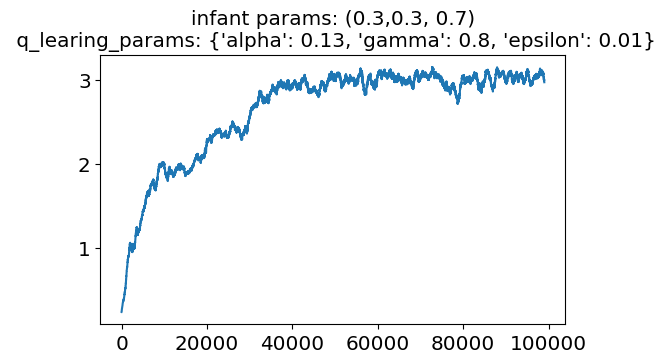

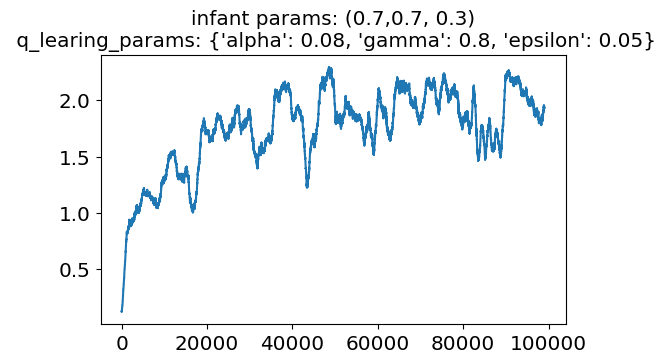

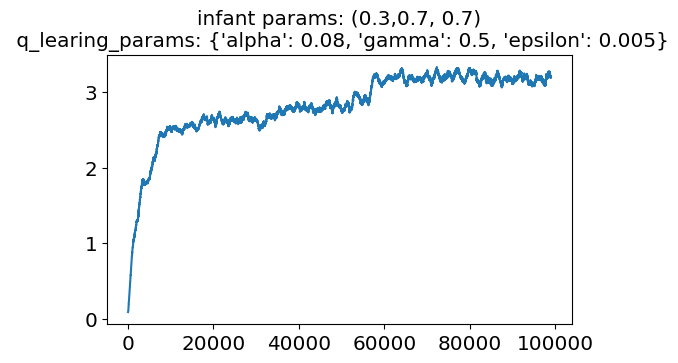

In [54]:
for i, row in results_df.sample(3).iterrows():
    avg = running_avg(row["rewards"], 1000, "valid")
    plot = sns.lineplot(avg)
    plot.set_title(
        f"infant params: ({row["perception"]},{row["persistence"]}, {row["coordination"]})\n q_learing_params: {row["infant_kwargs"]}"
    )
    plt.show()

### Get the best runs

In [55]:
top_percent_df = results_df

BEST_RUNS_AVG_STEPS = 5000


def get_run_max_reward(row):
    return np.max(running_avg(row["rewards"], BEST_RUNS_AVG_STEPS, "valid"))


top_percent_df["max_reward"] = [
    get_run_max_reward(row)
    for _i, row in tqdm(top_percent_df.iterrows(), total=len(top_percent_df))
]

top_percent_df = top_percent_df.sort_values("max_reward", ascending=False).head(
    int(len(top_percent_df) * 10 / 100)
)

100%|██████████| 144/144 [00:32<00:00,  4.49it/s]


### Learning curve for top 10%

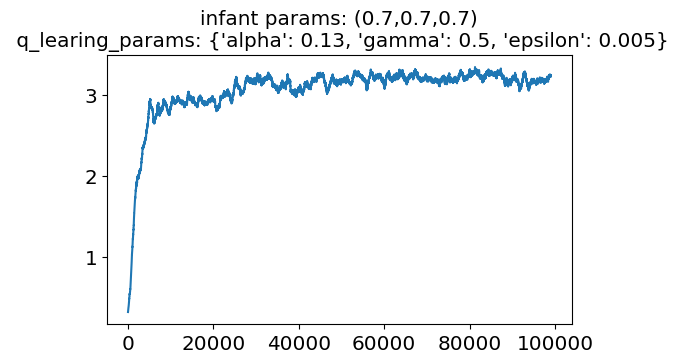

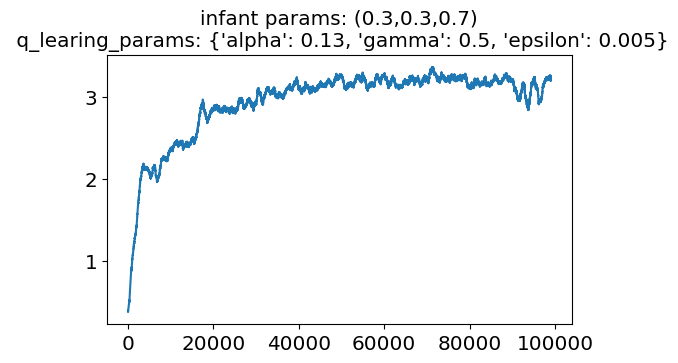

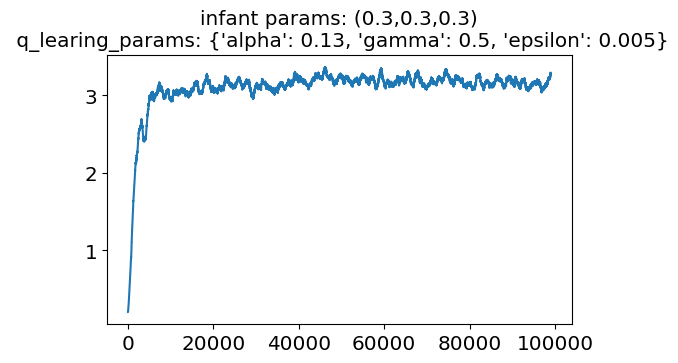

In [56]:
for i, row in top_percent_df.head(3).iterrows():
    avg = running_avg(row["rewards"], 1000, "valid")
    plot = sns.lineplot(avg)
    plot.set_title(
        f"infant params: ({row["perception"]},{row["persistence"]},{row["coordination"]})\n q_learing_params: {row["infant_kwargs"]}"
    )
    plt.show()

### Agregated result for top 10%

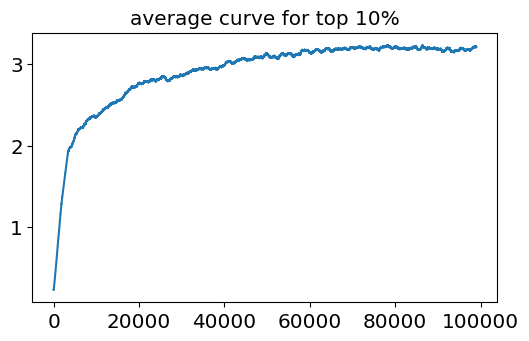

In [57]:
top_10_average_rewards = top_percent_df["rewards"].mean()

avg = running_avg(top_10_average_rewards, 1000, "valid")
plot = sns.lineplot(avg)
plot.set_title("average curve for top 10%")
plt.show()

## Show transitions table

In [60]:
def get_q_states_display(df):
    q_states = np.array(range(8)) if MODEL == "v0.2.0" else np.array(range(16))
    master_q_table = np.zeros(shape=results_df.iloc[0]["q_table"][0].shape)

    def action_to_str(a: int):
        match a:
            case 0:
                return "None"
            case 1:
                return "Parent"
            case _:
                return f"Toy{a - 1}"

    def get_percentage_str(state):
        transitions = master_q_table[state]
        total = np.sum(transitions)

        print_str = ""

        for action in np.argsort(-transitions):
            value = transitions[action] / total
            if value > 0.1:
                print_str += f"{action_to_str(action)}({value * 100:.1f}%), "

        q_states_display_df.iloc[state]

        return print_str

    for _i, row in df.iterrows():
        for q_table in row["q_table"]:
            argmax = np.argmax(q_table, axis=1)
            master_q_table[q_states, argmax] += 1

    q_states_display_df = pd.DataFrame(index=q_states)

    if MODEL == "v0.2.1":
        q_states_display_df["paired activity"] = [(s >> 3) % 2 == 1 for s in q_states]

    q_states_display_df["infant looked at toy"] = [(s >> 2) % 2 == 1 for s in q_states]
    q_states_display_df["parent looked at toy"] = [(s >> 1) % 2 == 1 for s in q_states]
    q_states_display_df["mutual gaze"] = [s % 2 == 1 for s in q_states]
    q_states_display_df["percentages"] = [get_percentage_str(s) for s in q_states]

    return q_states_display_df

### For all runs

In [61]:
q_states_display_df = get_q_states_display(results_df)
pd.set_option("max_colwidth", 100)
print("All runs")
q_states_display_df

All runs


,paired activity,infant looked at toy,parent looked at toy,mutual gaze,percentages
0,False,False,False,False,"Parent(99.4%),"
1,False,False,False,True,"Parent(98.1%),"
2,False,False,True,False,"Toy4(18.3%), Toy3(18.0%), Toy2(16.5%), None(16.1%), Toy1(16.0%), Parent(15.1%),"
3,False,False,True,True,"None(17.9%), Toy3(17.8%), Parent(17.1%), Toy2(16.6%), Toy1(15.9%), Toy4(14.7%),"
4,False,True,False,False,"Parent(67.0%), None(28.8%),"
5,False,True,False,True,"None(38.5%), Parent(35.6%),"
6,False,True,True,False,"Parent(74.7%), None(21.0%),"
7,False,True,True,True,"None(31.9%), Parent(23.1%), Toy2(12.3%), Toy4(11.0%), Toy1(11.0%), Toy3(10.6%),"
8,True,False,False,False,"Toy3(18.5%), Parent(18.3%), Toy4(16.4%), Toy1(16.2%), None(15.4%), Toy2(15.3%),"
9,True,False,False,True,"None(18.0%), Toy3(17.9%), Parent(16.3%), Toy2(16.2%), Toy4(16.2%), Toy1(15.3%),"


### For most successful runs

100%|██████████| 729/729 [01:17<00:00,  9.36it/s]


,perception,persistence,coordination,persistence_boost_value,coordination_boost_value,infant_kwargs,rewards,q_table,max_reward
0,0.2,0.2,0.2,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.01}","[0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, ...","[[[0.6251276554530036, 1.075482186908979, 0.12312183151064567, 0.14106755829182974, 0.1372590679...",0.29870
1,0.2,0.2,0.2,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.05}","[0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.7178827741870373, 1.0407360920049005, 0.15627098484525215, 0.15382285161113923, 0.163301804...",0.22654
2,0.2,0.2,0.2,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.7, 'epsilon': 0.1}","[0.1, 0.3, 0.1, 0.1, 0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...","[[[0.7545421564076988, 1.0938627567663997, 0.10279412095043786, 0.11734158363395408, 0.125078885...",0.13866
3,0.2,0.2,0.2,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.9, 'epsilon': 0.01}","[0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, ...","[[[0.6186792929288837, 1.195164611216833, 0.25089303703400834, 0.3725145859124899, 0.36693915040...",0.23974
4,0.2,0.2,0.2,0.0,0.0,"{'alpha': 0.05, 'gamma': 0.9, 'epsilon': 0.05}","[0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[2.8922594067638587, 3.564425847200735, 1.2796358561320365, 1.303314411834531, 1.3089492563477...",0.21426


### Top 10% runs

In [32]:
print(f"Top 10% best reward runs (avg for {BEST_RUNS_AVG_STEPS} steps)")
get_q_states_display(top_percent_df)

Top 10% best reward runs (avg for 5000 steps)


,infant looked at toy,parent looked at toy,mutual gaze,percentages
0,False,False,False,"Parent(100.0%),"
1,False,False,True,"Parent(98.6%),"
2,False,True,False,"Toy4(18.5%), Toy1(18.3%), None(17.1%), Toy3(16.2%), Parent(15.1%), Toy2(14.7%),"
3,False,True,True,"Toy3(19.0%), Parent(17.5%), Toy2(16.2%), Toy4(16.2%), Toy1(16.0%), None(15.0%),"
4,True,False,False,"Parent(63.1%), None(31.7%),"
5,True,False,True,"None(36.1%), Parent(35.0%),"
6,True,True,False,"Parent(83.8%), None(15.4%),"
7,True,True,True,"Parent(43.5%), None(35.6%),"


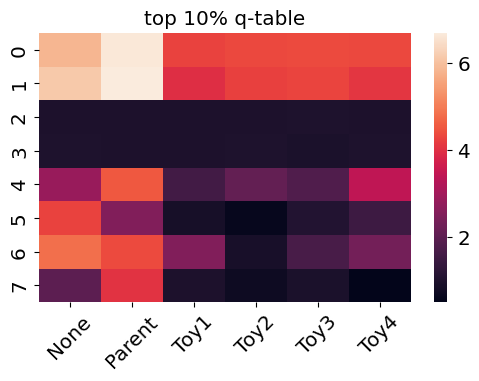

In [49]:
max_q_values = np.max(np.array(top_percent_df["q_table"].to_list()), axis=0)[0]
hm = sns.heatmap(max_q_values)
hm.set_xticklabels(["None", "Parent"] + [f"Toy{n}" for n in range(1, 5)], rotation=45)
hm.set_title("top 10% q-table")
plt.show()

## Maybe add some transition graph here? (which state leads to which other state)

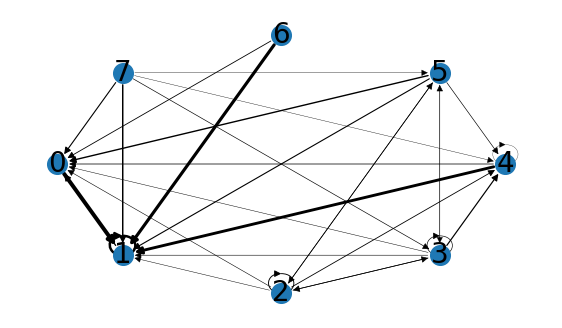

In [60]:
G = nx.DiGraph()

for i, row in enumerate(master_q_table):
    row_sum = np.sum(row)
    for j, w in enumerate(row):
        if w > 2:
            G.add_edge(i, j, weight=w / row_sum * 3)

pos = nx.shell_layout(
    G,
    # scale=20,
)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d["weight"])

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

plt.axis("off")
plt.show()